# 0. Instructions
- **Author:** Florian Kaiser
- **Last Update:** 02/23/17
- **Goal of Analysis:** Assess which of their new customers are likely to leave in the next quarter 
- **Table of Contents:**
[Data Preparation](#1)
[Churn Model](#2)
[Churn Prediction](#3)

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# <a id="1"></a> 1. Data Preparation

## 1.1 Data Prep: Account Activity

In [2]:
# Read in account activity data set
account_activity = pd.read_csv("account_activity.csv")
account_activity.head(2)

,Customer ID,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,total_Mins,Intl_Calls,Intl_Charge,Total_Charge,CustServ_Calls
0,9323a0a9273b4f1e,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,717.2,3,2.7,75.56,1
1,926c851dbe8e87fe,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,625.2,3,3.7,59.24,1


In [3]:
# Rename Customer ID column to Customer_ID for easier manipulation
account_activity.rename(columns = {'Customer ID':'Customer_ID'}, inplace=True)

In [4]:
# Display number of rows and columns 
account_activity.shape

(3373, 17)

In [5]:
# Display number of duplicate rows
print account_activity.duplicated().sum()
account_activity_duplicated = account_activity.loc[account_activity.duplicated(keep='first'),:]

40


In [6]:
# Drop duplicate rows
account_activity.drop_duplicates(keep='first',inplace=True)

## 1.2 Data Prep: Customer Info

In [7]:
# Read in customer info data set
customer_info = pd.read_csv("customer_info.csv")
customer_info.head(2)

,Customer ID,State,Area_Code,Phone,Intl_Plan,VMail_Plan,Churn
0,9323a0a9273b4f1e,KS,415,382-4657,no,yes,0
1,926c851dbe8e87fe,OH,415,371-7191,no,yes,0


In [8]:
# Rename Customer ID column to Customer_ID for easier manipulation
customer_info.rename(columns = {'Customer ID':'Customer_ID'}, inplace=True)

In [9]:
# Display number of rows and columns 
customer_info.shape

(3373, 7)

In [10]:
# Display number of duplicate rows
print customer_info.duplicated().sum()
customer_info_duplicated  = customer_info.loc[customer_info.duplicated(keep='first'),:]

40


In [11]:
# Check if duplicate rows in customer_info and account_activity are the same
pd.merge(customer_info_duplicated,account_activity_duplicated,on="Customer_ID").shape

(40, 23)

In [12]:
# Drop duplicate rows
customer_info.drop_duplicates(keep='first',inplace=True)

In [13]:
# Identified data error in area codes which only represent 3 unique area codes (San Jose, Oakland, San Francisco) even though  
# customer data maps out over the whole united states and thus column will be not considered going forward
print customer_info.Area_Code.value_counts()
print "-----------------------------"
print customer_info.State.value_counts().head(10)

# Drop Area_Code column
customer_info.drop(['Area_Code'],axis=1,inplace=True)

415    1655
510     840
408     838
Name: Area_Code, dtype: int64
-----------------------------
WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
Name: State, dtype: int64


# 1.3 Merge Account Activity with Customer Info

In [14]:
# Merge account activity with customer info data set 
old_customers = pd.merge(account_activity,customer_info,on="Customer_ID")
old_customers.shape

(3333, 22)

In [15]:
# Export old_customer dataframe to csv for visualization in Tableau
old_customers.to_csv("C:\\Users\\Florian\\Desktop\\Interworks_Assignment\\old_customers.csv")

# <a id="2"></a> 2. Churn Model

## 2.1 Data preparation

In [16]:
# Display column names
old_customers.columns

Index([u'Customer_ID', u'VMail_Message', u'Day_Mins', u'Day_Calls',
       u'Day_Charge', u'Eve_Mins', u'Eve_Calls', u'Eve_Charge', u'Night_Mins',
       u'Night_Calls', u'Night_Charge', u'Intl_Mins', u'total_Mins',
       u'Intl_Calls', u'Intl_Charge', u'Total_Charge', u'CustServ_Calls',
       u'State', u'Phone', u'Intl_Plan', u'VMail_Plan', u'Churn'],
      dtype='object')

In [17]:
# Assign target variable y
y = old_customers.Churn

In [18]:
# Drop for modeling purposes irrelevant variables
columns_drop = ['Customer_ID','State','Phone','Churn']
churn_df = old_customers.drop(columns_drop,axis=1)

In [19]:
# Convert 'yes'/'no' to boolean values
churn_df['Intl_Plan'] = churn_df.Intl_Plan.map({'no':0,'yes':1})
churn_df['VMail_Plan'] = churn_df.VMail_Plan.map({'no':0,'yes':1})
churn_df.head(2)

,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,total_Mins,Intl_Calls,Intl_Charge,Total_Charge,CustServ_Calls,Intl_Plan,VMail_Plan
0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,717.2,3,2.7,75.56,1,0,1
1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,625.2,3,3.7,59.24,1,0,1


In [20]:
# Look at correlation of input variables (-> variable / feature selection will be performed during modeling step)
corr = churn_df.corr()
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val > 0.8 else 'black'
    return 'color: %s' % color

corr_color = corr.style.applymap(color_negative_red)
corr_color

In [21]:
# Create data matrix X
X = churn_df.as_matrix().astype(np.float)

In [22]:
# Standardize data set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
print X.shape

(3333L, 18L)


In [23]:
print "Feature space holds %d observations and %d features" % X.shape

Feature space holds 3333 observations and 18 features


## 2.2 Modeling

In [24]:
# Split into training and validation data set
from sklearn import cross_validation
validation_size = 0.30
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, y, test_size=validation_size, random_state=seed)

In [25]:
# Tree-based Feature Selection to compute feature importances in order to discard irrelevant features
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier()
clf = clf.fit(X_train, Y_train)
print "Prev. Shape: ",X_train.shape
print X_train[0,:]

#print clf.feature_importances_

model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)
print "Aft. Shape: ",X_train_new.shape       
print X_train_new[0,:]

Prev. Shape:  (2333L, 18L)
[-0.59175986 -1.15086298  0.87532604 -1.15060002  0.95884956 -0.50775583
  0.95973076 -0.76477947 -0.8232638  -0.76435989  0.30905634 -0.57665489
 -0.19483061  0.31236723 -0.76373626  1.09264093 -0.32758048 -0.61839626]
Aft. Shape:  (2333L, 6L)
[-1.15086298 -1.15060002 -0.57665489 -0.76373626  1.09264093 -0.32758048]


In [26]:
# Evaluate Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train_new)
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []  
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

In [27]:
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train_new, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name) 
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.858965 (0.028099)
KNN: 0.897981 (0.014233)
CART: 0.887693 (0.018713)
SVM: 0.912131 (0.020850)
RF: 0.919405 (0.014644)


In [28]:
# Create validation data set only including relevant features after feature selection
X_validation_new = X_validation[:,[1,3,11,14,15,16]]

In [29]:
# Make predictions on validation dataset
results_valid_acc = []
results_valid_roc = []
names = []

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

for name, model in models:
    curr_model = model
    curr_model.fit(X_train_new, Y_train)
    predictions = curr_model.predict(X_validation_new)
    
    accuracy = accuracy_score(Y_validation, predictions)
    roc_auc = roc_auc_score(Y_validation, predictions)
    results_valid_acc.append(accuracy)
    results_valid_roc.append(roc_auc)
    names.append(name)
    msg = "%s - Acc: %f, ROC: %f" % (name, accuracy,roc_auc)
    print(msg)

LR - Acc: 0.846000, ROC: 0.550285
KNN - Acc: 0.898000, ROC: 0.749674
CART - Acc: 0.894000, ROC: 0.790155
SVM - Acc: 0.898000, ROC: 0.714864
RF - Acc: 0.913000, ROC: 0.801371


# <a id="3"></a> 3. Predict Churn for New Customers

## 3.1 Data Prep: New Customers

In [30]:
new_customers = pd.read_csv("new_customers.csv")
new_customers.head(2)

,State,Account_Length,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,total_Mins,Intl_Calls,Intl_Charge,Total_Charge,CustServ_Calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,717.2,3,2.7,75.56,1,NaN
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,625.2,3,3.7,59.24,1,NaN


In [31]:
# Display column names
new_customers.columns

Index([u'State', u'Account_Length', u'Area_Code', u'Phone', u'Intl_Plan',
       u'VMail_Plan', u'VMail_Message', u'Day_Mins', u'Day_Calls',
       u'Day_Charge', u'Eve_Mins', u'Eve_Calls', u'Eve_Charge', u'Night_Mins',
       u'Night_Calls', u'Night_Charge', u'Intl_Mins', u'total_Mins',
       u'Intl_Calls', u'Intl_Charge', u'Total_Charge', u'CustServ_Calls',
       u'Churn'],
      dtype='object')

In [32]:
# Display number of rows and columns 
new_customers.shape

(1809, 23)

In [33]:
# Display number of duplicate rows
print customer_info.duplicated().sum()

0


In [34]:
# Drop for scoring purposes irrelevant variables
columns_drop = ['Account_Length','State','Phone','Churn','Area_Code']
new_cust = new_customers.drop(columns_drop,axis=1)

In [35]:
# Convert 'yes'/'no' to boolean values
new_cust['Intl_Plan'] = new_cust.Intl_Plan.map({'no':0,'yes':1})
new_cust['VMail_Plan'] = new_cust.VMail_Plan.map({'no':0,'yes':1})

In [36]:
# Drop columns for feature selection / multicollinearity purposes 
columns_drop = ['VMail_Plan','VMail_Message','Day_Calls','Intl_Calls','Eve_Mins','Eve_Calls',
                'Eve_Charge','Night_Mins','Night_Calls','Night_Charge','Intl_Mins','Intl_Charge']
new_cust = new_cust.drop(columns_drop,axis=1)
new_cust.head(2)

,Intl_Plan,Day_Mins,Day_Charge,total_Mins,Total_Charge,CustServ_Calls
0,0,265.1,45.07,717.2,75.56,1
1,0,161.6,27.47,625.2,59.24,1


In [37]:
# Rearrange columns to fit old customer data set
new_cust = new_cust[['Day_Mins','Day_Charge','total_Mins','Total_Charge','CustServ_Calls','Intl_Plan']]
new_cust.head(2)

,Day_Mins,Day_Charge,total_Mins,Total_Charge,CustServ_Calls,Intl_Plan
0,265.1,45.07,717.2,75.56,1,0
1,161.6,27.47,625.2,59.24,1,0


In [38]:
# Create data matrix X
X_score = new_cust.as_matrix().astype(np.float)

In [39]:
# Standardize data set
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_score = scaler.fit_transform(X_score)

In [40]:
print "Feature space holds %d observations and %d features" % X_score.shape

Feature space holds 1809 observations and 6 features


## 3.2 Scoring New Customers 

In [41]:
# Create X_new which merges train and validation data set
X_new = np.concatenate((X_train_new,X_validation_new),axis=0)
print X_new.shape

(3333L, 6L)


In [42]:
# Score New Customer data set applying a RandomForest
RF = RandomForestClassifier()
RF.fit(X_new,y)
predictions = RF.predict(X_score)

In [43]:
# Display percentage of churn of new customers
count = 0
total = 0
for i in predictions:
    if i == 1:
        count+=1
    total+=1
print "% Churn New Customers: ",round((count / total),3)

% Churn New Customers:  0.061


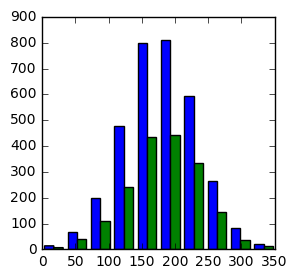

In [52]:
# Distribution of Day_Mins of old customers and new customers
plt.hist([churn_df.Day_Mins,new_cust.Day_Mins])
plt.rcParams["figure.figsize"] = (3,3)
plt.show()

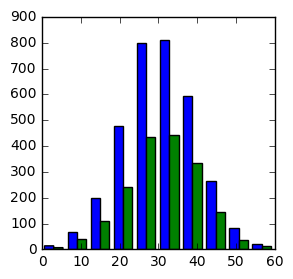

In [45]:
# Distribution of Day_Charge of old customers and new customers
plt.hist([churn_df.Day_Charge,new_cust.Day_Charge])
plt.rcParams["figure.figsize"] = (3,3)
plt.show()

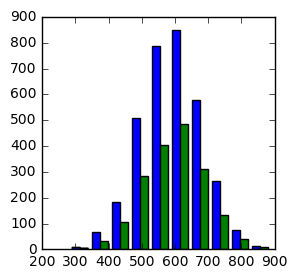

In [46]:
# Distribution of total_Mins of old customers and new customers
plt.hist([churn_df.total_Mins,new_cust.total_Mins])
plt.rcParams["figure.figsize"] = (3,3)
plt.show()

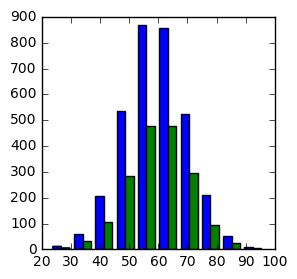

In [47]:
# Distribution of Total_Charge of old customers and new customers
plt.hist([churn_df.Total_Charge,new_cust.Total_Charge])
plt.rcParams["figure.figsize"] = (3,3)
plt.show()

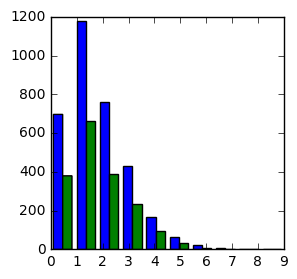

In [48]:
# Distribution of CustServ_Calls of old customers and new customers
plt.hist([churn_df.CustServ_Calls,new_cust.CustServ_Calls])
plt.rcParams["figure.figsize"] = (3,3)
plt.show()

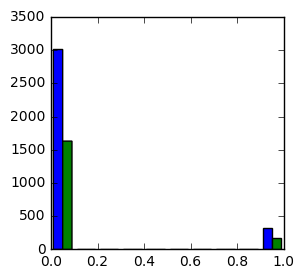

In [49]:
# Distribution of Intl_Plan of old customers and new customers
plt.hist([churn_df.Intl_Plan,new_cust.Intl_Plan])
plt.rcParams["figure.figsize"] = (3,3)
plt.show()

In [50]:
# Concatenate Churn_pred to new_customers data set
new_customers['Churn_pred'] = predictions

In [51]:
# Export scored new_customer dataframe to csv for visualization in Tableau
new_customers.to_csv("C:\\Users\\Florian\\Desktop\\Interworks_Assignment\\new_customers_scored.csv")